In [1]:
from pathlib import Path
import numpy as np
import pprint

from myTools.read_spikeglx import get_exp_path, get_geometry, get_channel_map, read_spikeglx_meta

from probeinterface import Probe
from probeinterface.plotting import plot_probe

import spikeinterface.full as si
# import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
# import spikeinterface.curation as scur
# import spikeinterface.widgets as sw


In [2]:
### Select experiment ###

from pathlib import Path
from myTools.read_spikeglx import get_exp_path, get_geometry, read_spikeglx_meta
dir_info = {
    "root_dir": r"C:\Users\tanaka-users\NeuronData",
    "name": "ge6w2",
    "ep": "005",
    "run": "002",
    "ng": "0",
    "nt": "0",
}

dict_path = get_exp_path(dir_info)

In [ ]:
### Setting sorters ###
do_preprocess = False
do_runsort = True
do_export_phy = False
# sorters = ["dartsort", "kilosort4", "spykingcircus2"]
# sorters = ["kilosort4"]
# sorters = ["spykingcircus2"]
sorters = ["dartsort"]

sort_params_ds = ss.DARTsortSorter.default_params()
sort_params_ks4 = ss.Kilosort4Sorter.default_params()
sort_params_sc2 = ss.Spykingcircus2Sorter.default_params()

# DARTsort用パラメータ（メモリ削減版）
# メモリ不足エラー対策: スパイク数を大幅に制限
sort_params_ds["gmm_max_spikes"] = 50000  # デフォルト: 2000000 → 50000に大幅削減（refine用）
sort_params_ds["clustering_max_spikes"] = 15000  # デフォルト: 100000 → 15000に削減
# チャンクサイズを小さくしてメモリ使用量を削減
sort_params_ds["chunk_duration"] = "0.5s"  # デフォルト: "1s" → 0.5sに短縮
sort_params_ds["chunk_length_samples"] = 15000  # デフォルト: 30000 → 15000に削減
# refinement をスキップまたは最小限に（メモリ不足回避）
if "n_refinement_iters" in sort_params_ds:
    sort_params_ds["n_refinement_iters"] = 0  # refinement をスキップ（メモリ削減）
# バッチサイズを小さくしてメモリ使用量を削減
if "batch_size" in sort_params_ds:
    sort_params_ds["batch_size"] = 16  # デフォルト: 256 → 16に大幅削減
# モーション推定を無効化してメモリ使用量を削減
sort_params_ds["do_motion_estimation"] = False  # モーション推定を無効化（メモリ削減）
# TPCA denoise を無効化してメモリ使用量を削減
sort_params_ds["do_tpca_denoise"] = False  # TPCAノイズ除去を無効化（メモリ削減）
# クラスタリングのワーカー数を減らしてメモリ使用量を削減
if "clustering_workers" in sort_params_ds:
    sort_params_ds["clustering_workers"] = 1  # デフォルト: 5 → 1に削減（メモリ削減）
# GMM refinement用のパラメータを調整
if "gmm_val_proportion" in sort_params_ds:
    sort_params_ds["gmm_val_proportion"] = 0.1  # デフォルト: 0.25 → 0.1に削減（メモリ削減）
if "gmm_n_candidates" in sort_params_ds:
    sort_params_ds["gmm_n_candidates"] = 3  # デフォルト: 5 → 3に削減（メモリ削減）

# 特徴量抽出のロバスト性を向上（NaN/Inf回避）
if "correlation_threshold" in sort_params_ds:
    sort_params_ds["correlation_threshold"] = 0.05  # デフォルト: 0.1 → 0.05に下げる（より多くのスパイクを検出）
if "initial_threshold" in sort_params_ds:
    sort_params_ds["initial_threshold"] = 12.0  # デフォルト: 16.0 → 12.0に下げる（より多くのスパイクを検出）
# 特徴量の正規化を調整
if "initial_pc_scale" in sort_params_ds:
    sort_params_ds["initial_pc_scale"] = 3.0  # デフォルト: 5.0 → 3.0に下げる（特徴量のスケールを小さく）
# クラスタリングの閾値を調整
if "gmm_cosine_threshold" in sort_params_ds:
    sort_params_ds["gmm_cosine_threshold"] = 0.7  # デフォルト: 0.75 → 0.7に下げる（より緩い閾値）
if "gmm_euclidean_threshold" in sort_params_ds:
    sort_params_ds["gmm_euclidean_threshold"] = 4.0  # デフォルト: 5.0 → 4.0に下げる（より緩い閾値）

# Kilosort4用パラメータ
name_thisparam = "default"
sort_params_ks4["torch_device"] = "cuda"
sort_params_ks4["save_extra_vars"] = True
sort_params_ks4["skip_kilosort_preprocessing"] = do_preprocess
# sort_params_ks4["nt"] = 61
# Spykingcircus2用パラメータ（必要に応じて調整）


In [4]:
### Fetch meta and bin files ###

meta_ap = read_spikeglx_meta(dict_path["ap"]["meta"])
meta_lf = read_spikeglx_meta(dict_path["lf"]["meta"])
meta_obx = read_spikeglx_meta(dict_path["obx"]["meta"])


In [5]:
### Get recording info ###

sampling_frequency = float(meta_ap['imSampRate'])
num_channels = int(meta_ap['nSavedChans'])
num_frames = int(meta_ap.get('fileSizeBytes', 0)) // (num_channels * 2)  # 2 bytes per sample (int16)
print(f"{sampling_frequency}Hz - {num_channels}chan - {num_frames / sampling_frequency:.2f} sec")

30000.0Hz - 385chan - 522.62 sec


In [6]:
## Get AP recording ###

import spikeinterface as si  # import core only
recording = si.read_binary(
    file_paths=dict_path["ap"]["bin"],
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)
sync_recording = recording.select_channels([num_channels-1])
recording = recording.select_channels(np.arange(num_channels-1))

sync_recording

ChannelSliceRecording: 1 channels - 30.0kHz - 1 segments - 15,678,482 samples 
                       522.62s (8.71 minutes) - int16 dtype - 29.90 MiB

プローブを作成しました: Probe - imec - NP1110 - 21144109852 - 384ch - 1shanks
コンタクト数: 384
位置情報の形状: (384, 2)


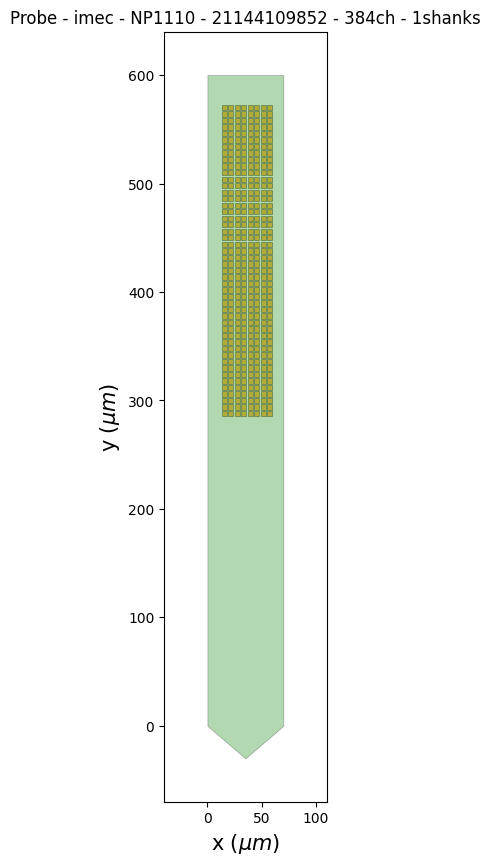

In [7]:
### Create probe manually from meta file ###

from pathlib import Path
import numpy as np
import re
from probeinterface import Probe
from probeinterface.io import write_prb
from probeinterface.plotting import plot_probe


# snsGeomMapから位置情報を取得
geom_str = meta_ap.get('~snsGeomMap', '')
if not geom_str:
    raise ValueError("snsGeomMap not found in meta file")

# snsGeomMapを解析
# 形式: (NP1110,1,0,73)(0:15.5:0:1)(0:57.5:42:1)...
geom_list = geom_str.split(')')

# 最初のエントリからプローブ情報を取得
probe_info = geom_list[0][1:].split(',')  # (NP1110,1,0,73) -> ['NP1110', '1', '0', '73']
probe_type = probe_info[0]
num_shanks = int(probe_info[1])
shank_pitch = float(probe_info[2])
shank_width = float(probe_info[3])

# 位置情報を抽出
positions = []
shank_ids = []
activated = []
for geom_entry in geom_list[1:-1]:  # 最初と最後を除外
    if geom_entry:
        # (0:15.5:0:1) -> ['0', '15.5', '0', '1']
        parts = geom_entry[1:].split(':')
        shank_id = int(parts[0])
        x = float(parts[1])
        y = float(parts[2])
        act = int(parts[3])
        positions.append([x, y])
        shank_ids.append(shank_id)
        activated.append(act)

positions = np.array(positions)
shank_ids = np.array(shank_ids)
activated = np.array(activated)

# 保存されているチャンネルを取得
saved_chans_str = meta_ap.get('snsSaveChanSubset', 'all')
if saved_chans_str == 'all':
    n_saved_chans = int(meta_ap.get('nSavedChans', len(positions)))
    saved_chans = np.arange(n_saved_chans)
else:
    saved_chans = []
    for e in saved_chans_str.split(','):
        if ':' in e:
            start, stop = e.split(':')
            start, stop = int(start), int(stop) + 1
            saved_chans.extend(np.arange(start, stop))
        else:
            saved_chans.append(int(e))
    saved_chans = np.array(saved_chans)

# プローブオブジェクトを作成
probe = Probe(ndim=2, si_units='um', model_name='NP1110', manufacturer='imec')

# コンタクトを設定
probe.set_contacts(
    positions=positions,
    shapes='square',
    shank_ids=shank_ids,
    shape_params={'width': 5.0}  # NP1110の電極サイズ
)

# デバイスチャンネルインデックスを初期設定（元の順序）
probe.set_device_channel_indices(np.arange(len(positions)))
recording = recording.set_probe(probe)

# 深さ順の順序を取得
order_f, order_r = si.order_channels_by_depth(recording)

# 深さ順に並び替えたpositionsを作成
sorted_positions = positions[order_f]
sorted_shank_ids = shank_ids[order_f] if shank_ids is not None else None

# 新しいプローブを作成（深さ順に並び替えた位置情報を使用）
probe_sorted = Probe(ndim=2, si_units='um', model_name='NP1110', manufacturer='imec')
probe_sorted.set_contacts(
    positions=sorted_positions,
    shapes='square',
    shank_ids=sorted_shank_ids,
    contact_ids=np.arange(len(sorted_positions)),
    shape_params={'width': 5.0}
)

# device_channel_indicesには、深さ順に並び替えた後の各電極が
# 元のバイナリファイルの何番目の行にあったかを示すインデックスを設定
# order_f[i]は、深さ順に並び替えた後のi番目の電極が、元のデータのorder_f[i]番目だったことを示す
probe_sorted.set_device_channel_indices(order_f)

# プローブの輪郭を設定
# probe_sorted.create_auto_shape()
contour_polygon = [
    [0, 600],    # 左上
    [70, 600],    # 右上
    [70, 0],    # 右下
    [35, -30],     # 先端（頂点）
    [0,  0],   # 左下
    
]

# numpy配列に変換してセット
contour_array = np.array(contour_polygon)
probe_sorted.set_planar_contour(contour_array)

# アノテーションを追加
probe_sorted.annotate(
    serial_number=meta_ap.get('imDatPrb_sn'),
    part_number=meta_ap.get('imDatPrb_pn'),
    port=meta_ap.get('imDatPrb_port'),
    slot=meta_ap.get('imDatPrb_slot'),
)

# 並び替えたプローブをrecordingに設定
recording = recording.set_probe(probe_sorted)
probe = probe_sorted  # 後続のコードでprobeを使う場合に備えて更新

print(f"プローブを作成しました: {probe}")
print(f"コンタクト数: {probe.get_contact_count()}")
print(f"位置情報の形状: {positions.shape}")

# プローブを可視化
import matplotlib.pyplot as plt
plt.rcParams["svg.fonttype"] = "none"
fig, ax = plt.subplots(figsize=(10, 10))
plot_probe(probe, ax=ax)
# plot_probe(probe, with_contact_id=True, with_device_index=True, xlims=(0, 100), ylims=(280, 350))
fig.savefig("probe.svg", format="svg")

In [8]:
channel_ids = recording.get_channel_ids()
print(channel_ids)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [9]:
pg = recording.get_probegroup()
pg.to_dataframe()

,probe_index,x,y,contact_shapes,width,shank_ids,contact_ids
0,0,27.5,288.0,square,5.0,0,2
1,0,45.5,330.0,square,5.0,0,61
2,0,33.5,288.0,square,5.0,0,3
3,0,39.5,330.0,square,5.0,0,60
4,0,27.5,294.0,square,5.0,0,10
...,...,...,...,...,...,...,...
379,0,51.5,534.0,square,5.0,0,334
380,0,15.5,570.0,square,5.0,0,376
381,0,57.5,528.0,square,5.0,0,327
382,0,21.5,570.0,square,5.0,0,377


In [10]:
### Get probe geometry ###

import numpy as np
geometry = get_geometry(meta_ap)
unique_x = np.sort(np.unique(geometry[:,0]))
print(f"Unique x positions: {unique_x}")
unique_y = np.sort(np.unique(geometry[:,1]))
print(f"Unique y positions: {unique_y}")

print(recording.get_channel_ids())

Unique x positions: [15.5 21.5 27.5 33.5 39.5 45.5 51.5 57.5]
Unique y positions: [288. 294. 300. 306. 312. 318. 324. 330. 336. 342. 348. 354. 360. 366.
 372. 378. 384. 390. 396. 402. 408. 414. 420. 426. 432. 438. 444. 450.
 456. 462. 468. 474. 480. 486. 492. 498. 504. 510. 516. 522. 528. 534.
 540. 546. 552. 558. 564. 570.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165

In [11]:
### Set gain and offset to recording ###

im_ai_range_max = float(meta_ap.get('imAiRangeMax', 0.6))
im_ai_range_min = float(meta_ap.get('imAiRangeMin', -0.6))
im_max_int = int(meta_ap.get('imMaxInt', 512))
ap_gain = float(meta_ap.get('imChan0apGain', 500))

# μVへの変換係数
gain_to_uv = (im_ai_range_max - im_ai_range_min) / (2 * im_max_int * ap_gain) * 1e6

# 現在のrecordingのチャンネル数を取得（SYNCチャンネルを除外した場合は384）
current_num_channels = recording.get_num_channels()

# すべてのチャンネルに同じゲインを設定
gains = np.full(current_num_channels, gain_to_uv, dtype='float32')
recording.set_channel_gains(gains)

# オフセットは0に設定
offsets = np.zeros(current_num_channels, dtype='float32')
recording.set_channel_offsets(offsets)
recording

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 15,678,482 samples 
                       522.62s (8.71 minutes) - int16 dtype - 11.21 GiB

In [12]:
# def probe_to_ks4_dict(probe):
#     # 電極位置の取得
#     positions = probe.contact_positions
#     xc = positions[:, 0]
#     yc = positions[:, 1]
    
#     # kcoords（シャンクID）の設定
#     # マルチシャンクプローブの場合はshank_idsを使用、なければすべて1とする
#     if probe.shank_ids is not None:
#         # 文字列IDを整数に変換する必要がある場合があるためユニークIDをマップ
#         u_shanks, kcoords = np.unique(probe.shank_ids, return_inverse=True)
#         kcoords = kcoords
#     else:
#         kcoords = np.zeros(len(xc))

#     # chanMap（デバイスのチャンネルインデックス）
#     chan_map = probe.device_channel_indices
#     if chan_map is None:
#         raise ValueError("Probeオブジェクトにdevice_channel_indicesが設定されていません。")

#     # KS4が期待する辞書形式
#     probe_dict = {
#         'xc': xc,
#         'yc': yc,
#         'kcoords': kcoords,
#         'chanMap': chan_map,
#         'n_chan': len(chan_map)
#     }
#     return probe_dict

# probe_dict = probe_to_ks4_dict(probe)

# import json
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         # Handle numpy integers/floats if necessary
#         if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
#                             np.int16, np.int32, np.int64, np.uint8,
#                             np.uint16, np.uint32, np.uint64)):
#             return int(obj)
#         if isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
#             return float(obj)
#         return super().default(obj)

# # 2. Use it in your existing code

# with open(dict_path["exp"] / "kilosort4" / "chanMap.json", "w") as f:
#     json.dump(probe_dict, f, indent=4, cls=NumpyEncoder)

In [13]:
### Check GPU memory ###    

import torch
import gc

print("実行前のGPUメモリ状態:")
if torch.cuda.is_available():
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    
    # GPUキャッシュをクリア
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nクリア後のGPUメモリ状態:")
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("  CUDAが利用できません")

実行前のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB

クリア後のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB


In [14]:
### Preprocess recording ###
import json
if do_preprocess:
    # パラメータ辞書を作成
    sort_params_dict = {
        "DARTsort": sort_params_ds,
        "kilosort4": sort_params_ks4,
        "spykingcircus2": sort_params_sc2
    }

    # 選択されたソーターのパラメータを表示
    print("\n" + "="*20 + " parameter " + "="*20)
    for sorter in sorters:
        print(f"\n{'='*5} {sorter} {'='*5}")
        pprint.pprint(sort_params_dict[sorter])

        # ディレクトリが存在しない場合は作成
        params_file = dict_path["exp"] / sorter / name_thisparam / "params.txt"
        params_file.parent.mkdir(parents=True, exist_ok=True)
        with open(str(params_file), "w", encoding="utf-8") as f:
            json.dump(sort_params_dict[sorter], f, indent=4, ensure_ascii=False)

    for sorter in sorters:

        print("="*5, sorter, "="*5)
        folder = dict_path["exp"] / sorter / name_thisparam
        pp_rec_folder = folder / "pp_rec"

        if sorter == "kilosort4":
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global")
            recording_whiten = spre.whiten(recording_cmr, int_scale=200)
            recording_motion = spre.correct_motion(recording_whiten, preset="kilosort_like")
            recording_preprocessed = recording_motion.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
        else:
            # DARTsort用前処理（NaN/Inf を避けるためmean common referenceを使用）
            print(f"  バンドパスフィルタ適用中...")
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            
            # medianではなくmean common referenceを使用（NaN生成を回避）
            # medianは同じ値が続く場合や極端な値がある場合にNaNを生成する可能性がある
            print(f"  Common reference適用中... (mean)")
            try:
                recording_cmr = spre.common_reference(recording_f, reference="global", operator="mean")
            except Exception as e:
                print(f"  Common reference (mean) でエラー: {e}")
                print(f"  フォールバック: median common referenceを使用")
                recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            
            # 前処理recordingを保存（NaN/Infチェックは後で実行）
            recording_preprocessed = recording_cmr.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
            
            print(f"  前処理完了: {recording_preprocessed.get_num_channels()}チャンネル, {recording_preprocessed.get_num_frames()}フレーム")
else:
    print("skip preprocessing.")

skip preprocessing.


In [15]:
### Run sort ###

import torch
import gc
import traceback
import time
import logging
from datetime import datetime

# DARTsortのログレベルを上げて詳細を表示
logging.getLogger("dartsort").setLevel(logging.INFO)
logging.getLogger("spikeinterface.sorters").setLevel(logging.INFO)

if do_runsort:
    sorting_list = []
    analyzer_list = []
    for sorter in sorters:
        print("="*5, sorter, "="*5)
        print(f"開始時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        if not do_preprocess:
            # recording_preprocessed = si.load(exp_dir / sorter / "pp_rec")
            recording_preprocessed = recording

        try:
            print(f"  ソーター実行開始: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            start_time = time.time()
            
            # メモリをクリア（実行前）
            import sys
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            # numpyのメモリプールをクリア（可能な場合）
            try:
                import numpy as np
                # numpyのメモリプールをリセット（メモリ断片化を防ぐ）
                if hasattr(np, '_get_global_state'):
                    # numpyの内部状態をリセット
                    pass
            except:
                pass
            
            # メモリ使用量を表示
            if torch.cuda.is_available():
                print(f"  実行前GPUメモリ: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB / {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
            
            # システムメモリ使用量を表示
            try:
                import psutil
                process = psutil.Process()
                mem_info = process.memory_info()
                print(f"  実行前システムメモリ: {mem_info.rss / 1024**3:.2f} GB (RSS)")
            except ImportError:
                print("  psutilがインストールされていません。システムメモリ使用量を表示できません。")
            
            # ソーター出力ディレクトリを表示
            sorter_output_dir = dict_path["exp"] / sorter / name_thisparam / "sorting"
            print(f"  ソーター出力ディレクトリ: {sorter_output_dir}")
            print(f"  ログファイル: {sorter_output_dir / 'spikeinterface_log.json'}")
            print(f"  トレースバックファイル: {sorter_output_dir / 'traceback.txt'}")
            
            sorting = ss.run_sorter(
                sorter_name=sorter,
                folder=sorter_output_dir, 
                remove_existing_folder=True, 
                recording=recording_preprocessed,
                verbose=True,  # 詳細ログを有効化
                **sort_params_dict[sorter]
                )
            
            elapsed_time = time.time() - start_time
            print(f"  ソーター実行完了: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} (経過時間: {elapsed_time/60:.1f}分)")

            print(f"  Analyzer作成開始: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            analyzer_dir = dict_path["exp"] / sorter / name_thisparam / "analyzer"
            analyzer = si.create_sorting_analyzer(
                sorting=sorting, 
                recording=recording_preprocessed, 
                format='binary_folder', 
                folder=analyzer_dir, 
                overwrite=True
                )
            print(f"  Analyzer作成完了: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            
            print("===== Sorting done =====")

        except Exception as e:
            print(f"Error occurred while running {sorter}: {e}")
            traceback.print_exc()
            
            # エラー時もメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
            continue
        finally:
            
            # 各ソーター実行後にGPUメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
                print(f"  GPUメモリクリア完了 - 割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
else:
    print("skip sorting.")

===== dartsort =====
開始時刻: 2026-01-27 19:36:28
  ソーター実行開始: 2026-01-27 19:36:28
  実行前GPUメモリ: 0.00 GB / 0.00 GB
  実行前システムメモリ: 0.88 GB (RSS)
  ソーター出力ディレクトリ: C:\Users\tanaka-users\NeuronData\ge6w2\ge6w2_ep005_002\dartsort\default\sorting
  ログファイル: C:\Users\tanaka-users\NeuronData\ge6w2\ge6w2_ep005_002\dartsort\default\sorting\spikeinterface_log.json
  トレースバックファイル: C:\Users\tanaka-users\NeuronData\ge6w2\ge6w2_ep005_002\dartsort\default\sorting\traceback.txt
Error occurred while running dartsort: name 'sort_params_dict' is not defined


Traceback (most recent call last):
  File "C:\Users\tanaka-users\AppData\Local\Temp\ipykernel_22588\1787068760.py", line 71, in <module>
    **sort_params_dict[sorter]
      ^^^^^^^^^^^^^^^^
NameError: name 'sort_params_dict' is not defined


  GPUメモリクリア完了 - 割り当て済み: 0.00 GB


In [16]:
### export to phy ###

if do_export_phy:
    analyzer = si.load_sorting_analyzer(folder= dict_path["exp"] / sorter / name_thisparam / "analyzer")
    analyzer.compute(['random_spikes', 'waveforms', 'templates'])
    # PC特徴の計算が時間かかってそうなので、Falseにしておく
    sexp.export_to_phy(sorting_analyzer=analyzer, output_folder=dict_path["exp"] / sorter / name_thisparam / "phy", remove_if_exists=True,
                            compute_pc_features=False)
else:
    print("skip export to phy.")

skip export to phy.


In [17]:
### load sorting and analyzer ###
sorter = sorters[0]
sorting = si.load(dict_path["exp"] / sorter / name_thisparam / "sorting")
analyzer = si.load(dict_path["exp"] / sorter / name_thisparam / "analyzer")

ValueError: Folder C:\Users\tanaka-users\NeuronData\ge6w2\ge6w2_ep005_002\dartsort\default\sorting does not exist

In [ ]:
### export to matlab files for ks4 ###

from myTools.exchange import exchange_kilosort4_results
from kilosort.io import load_ops
import pandas as pd
import numpy as np


def safe_load_npy(file_path, allow_pickle=True):
    try:
        return np.load(file_path, allow_pickle=allow_pickle)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.array([])

def safe_load_csv(file_path, sep="\t"):
    try:
        return pd.read_csv(file_path, sep=sep).to_numpy()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

res_dir = dict_path["exp"] / sorter / name_thisparam / "sorting" / "sorter_output"

amplitudes = safe_load_npy(res_dir / "amplitudes.npy")
channel_map = safe_load_npy(res_dir / "channel_map.npy")
channel_positions = safe_load_npy(res_dir / "channel_positions.npy")
channel_shanks = safe_load_npy(res_dir / "channel_shanks.npy")
cluster_Amplitude = safe_load_csv(res_dir / "cluster_Amplitude.tsv", sep="\t")
cluster_ContamPct = safe_load_csv(res_dir / "cluster_ContamPct.tsv", sep="\t")
cluster_group = safe_load_csv(res_dir / "cluster_group.tsv", sep="\t")
cluster_KSLabel = safe_load_csv(res_dir / "cluster_KSLabel.tsv", sep="\t")
kept_spikes = safe_load_npy(res_dir / "kept_spikes.npy")
ops = load_ops(res_dir / "ops.npy")
pc_features_ind = safe_load_npy(res_dir / "pc_features_ind.npy")
pc_features = safe_load_npy(res_dir / "pc_features.npy")
similar_templates = safe_load_npy(res_dir / "similar_templates.npy")
spike_clusters = safe_load_npy(res_dir / "spike_clusters.npy")
spike_detection_templates = safe_load_npy(res_dir / "spike_detection_templates.npy")
spike_positions = safe_load_npy(res_dir / "spike_positions.npy")
spike_templates = safe_load_npy(res_dir / "spike_templates.npy")
spike_times = safe_load_npy(res_dir / "spike_times.npy")
templates = safe_load_npy(res_dir / "templates.npy")
templates_ind = safe_load_npy(res_dir / "templates_ind.npy")
whitening_mat = safe_load_npy(res_dir / "whitening_mat.npy")
whitening_mat_data = safe_load_npy(res_dir / "whitening_mat_dat.npy")
whitening_mat_inv = safe_load_npy(res_dir / "whitening_mat_inv.npy")


Error loading C:\Users\tanaka-users\NeuronData\ge6w2\ge6w2_ep005_002\kilosort4\default\sorting\sorter_output\pc_features_ind.npy: [Errno 2] No such file or directory: 'C:\\Users\\tanaka-users\\NeuronData\\ge6w2\\ge6w2_ep005_002\\kilosort4\\default\\sorting\\sorter_output\\pc_features_ind.npy'


In [ ]:
duration_sec = 1.0
n_channels_tot = recording.get_num_channels()

n_unit, n_sample, n_chan = templates.shape
templates_p2p = np.ptp(templates, axis=1)

best_channels_idx = np.argmax(templates_p2p, axis=1)

signal_amplitudes = templates_p2p[np.arange(n_unit), best_channels_idx]

sampling_rate = recording.get_sampling_frequency()
n_samples_to_load = int(sampling_rate * duration_sec)

file_size_bytes = recording.get_memory_size()
itemsize = recording.get_dtype().itemsize
total_samples = file_size_bytes // (n_channels_tot * itemsize)

total_frames = recording.get_num_frames()

start_frame = total_frames // 2

data_raw = recording.get_traces(start_frame=start_frame, end_frame=start_frame + n_samples_to_load)

# 中央値（Median）を引いてオフセットやドリフトの影響を除去
# abs(x - median(x))
d = np.abs(data_raw - np.median(data_raw, axis=0))

mad = np.median(d, axis=0)

# MADを標準偏差(sigma)相当に変換する定数 0.6745 で割る
noise_levels = mad / 0.6745

snr_data = []

for i in range(n_unit):
    # そのユニットのベストチャンネル（最大振幅チャンネル）のインデックス
    best_ch = best_channels_idx[i]
    
    # 信号強度 (Signal): 既に計算済みの templates_p2p から取得
    sig_val = signal_amplitudes[i]
    
    # ノイズレベル (Noise): ベストチャンネルのノイズを使用
    # recordingのチャンネル順序とtemplatesのチャンネル順序が一致している前提です
    if best_ch < len(noise_levels):
        noise_val = noise_levels[best_ch]
    else:
        noise_val = np.nan
        
    # SNR計算 (ゼロ除算を回避)
    if noise_val > 0:
        snr_val = sig_val / noise_val
    else:
        snr_val = 0
        
    snr_data.append({
        'unit_index': i,          # テンプレート内のインデックス
        'snr': snr_val,           # 計算されたSN比
        'best_channel': best_ch,  # 最もS/Nが良いチャンネル
        'signal_p2p': sig_val,    # 信号の高さ
        'noise_std': noise_val    # ノイズの大きさ
    })

# 3. 結果を見やすくDataFrameにまとめる
import pandas as pd
df_snr = pd.DataFrame(snr_data)

print(f"SNR計算完了: {len(df_snr)} units")
print(df_snr.head())

df_save = df_snr.copy()
if 'unit_index' in df_save.columns:
    df_save = df_save.rename(columns={'unit_index': 'cluster_id'})

# 必須ではありませんが、Phyで見やすくするために小数点以下を丸める
if 'snr' in df_save.columns:
    df_save['snr'] = df_save['snr'].round(3)
    
tsv_filename = res_dir / 'cluster_snr.tsv'
df_save.to_csv(tsv_filename, sep='\t', index=False)

if 'snr' in df_save.columns:
    npy_filename = res_dir / 'cluster_snr.npy'
    np.save(npy_filename, df_save['snr'].values)

cluster_snr = np.column_stack((
    df_save['snr'].values,
    df_save['signal_p2p'].values,
    df_save['noise_std'].values
))

print(cluster_snr.shape)

SNR計算完了: 438 units
   unit_index       snr  best_channel  signal_p2p  noise_std
0           0  0.355189            29    3.159574   8.895478
1           1  0.252886            32    2.249545   8.895478
2           2  0.255103            29    2.269267   8.895478
3           3  0.748420            32    6.657551   8.895478
4           4  0.479721            61    3.556122   7.412898
(438, 3)


In [ ]:

from scipy.io import savemat
import numpy as np
import torch

def replace_none_recursive(data):
    # 辞書の場合の処理
    if isinstance(data, dict):
        return {
            str(k) if isinstance(k, int) else k: replace_none_recursive(v) 
            for k, v in data.items()
        }
    
    # リストやタプルの場合の処理
    elif isinstance(data, (list, tuple)):
        # リスト内包表記で各要素を再帰的に処理
        return type(data)(replace_none_recursive(item) for item in data)
    
    # PyTorchテンソルの場合の処理（CPUに移動してnumpy配列に変換）
    elif isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    
    # numpy配列の場合の処理
    elif isinstance(data, np.ndarray):
        return data
    
    # numpy dtype の場合の処理（文字列に変換）
    elif isinstance(data, np.dtype):
        return str(data)
    
    # 値が None の場合の処理
    elif data is None:
        return 'None'
    
    # その他の値（文字列、数値など）はそのまま返す
    else:
        return data

replaced_ops = replace_none_recursive(ops)
savemat(res_dir / 'ops.mat', {'ops': replaced_ops}, long_field_names=True)
results_dict = {
    'amplitudes': amplitudes,
    'spike_times': spike_times,
    'spike_positions': spike_positions,
    'pc_features': pc_features,
    'templates': templates,
    'similar_templates': similar_templates,
    'cluster_KSLabel': cluster_KSLabel,
    'cluster_ContamPct': cluster_ContamPct,
    'cluster_Amplitude': cluster_Amplitude,
    'cluster_snr': cluster_snr,
    'spike_clusters': spike_clusters,
    'kept_spikes': kept_spikes,
    'pc_features_ind': pc_features_ind,
    'similar_templates': similar_templates,
    'spike_templates': spike_templates,
    'spike_positions': spike_positions,
    'spike_templates': spike_templates,
    'whitening_mat': whitening_mat,
    'whitening_mat_data': whitening_mat_data,
    'whitening_mat_inv': whitening_mat_inv,
}

savemat(res_dir / 'results.mat', results_dict, long_field_names=True, format='5')



In [ ]:
### export to probe.json ###

from probeinterface.io import write_probeinterface

write_probeinterface(res_dir / 'probe.json', probe_or_probegroup=probe)

In [ ]:
from kilosort.run_kilosort import load_sorting
ks_dir = dict_path["exp"] / sorter / name_thisparam / "sorting" / "sorter_output"
ops, st, clu, similar_templates, \
    is_ref, est_contam_rate, kept_spikes, \
        tF, Wall, full_st, full_clu, full_amp = \
            load_sorting(ks_dir, device="cuda", load_extra_vars=True)

from kilosort.plots import plot_drift_amount, plot_drift_scatter, plot_diagnostics, plot_spike_positions
plot_drift_amount(ops, ks_dir)
plot_drift_scatter(full_st, ks_dir)
plot_diagnostics(Wall, full_clu, ops, ks_dir)
plot_spike_positions(clu, is_ref, ks_dir)



In [ ]:
from scipy.io import savemat

fs_obx = float(meta_obx['obSampRate'])
n_chan_obx = int(meta_obx['nSavedChans'])
n_frame_obx = int(meta_obx.get('fileSizeBytes',0)) // (n_chan_obx * 2)
print(f"{fs_obx}Hz - {n_chan_obx}chan - {n_frame_obx / fs_obx:.2f} sec")

obx_rec = si.read_binary(
    dict_path["obx"]["bin"],
    fs_obx,
    'int16',
    n_chan_obx,
    time_axis=0,
    is_filtered=False
)

sig_stim = np.array(obx_rec.select_channels([n_chan_obx-1]).get_traces())
sig_stim_flat = sig_stim.flatten()
sig_binary = (sig_stim_flat > 0).astype(int)

# エッジ検出（差分を取る）
diff_not_zeros = np.diff(sig_binary)

# 立ち上がりエッジを検出（0→1の変化）
edge_rise = np.where(diff_not_zeros == 1)[0] + 1

# 立ち下がりエッジを検出（1→0の変化）
edge_fall = np.where(diff_not_zeros == -1)[0] + 1

# データの最初のサンプルで既に信号が立っている場合の取り逃しを防ぐ
if len(sig_binary) > 0 and sig_binary[0] > 0:
    edge_rise = np.concatenate([[0], edge_rise])

# データの最後のサンプルで信号が立っている場合の取り逃しを防ぐ
if len(sig_binary) > 0 and sig_binary[-1] > 0:
    edge_fall = np.concatenate([edge_fall, [len(sig_binary) - 1]])

# ソートして重複を除去（念のため）
edge_rise = np.unique(edge_rise)
edge_fall = np.unique(edge_fall)

savemat(
    res_dir / 'stim_times.mat',
    {
        'edge_rise': edge_rise,
        'edge_fall': edge_fall,
        'fs': fs_obx
    }
)
print(edge_rise)
print(len(edge_rise))
print(np.diff(edge_rise))
print(np.diff(edge_rise) / 30303)
print(np.argwhere(np.diff(edge_rise) / 30303 > 3))


30303.0Hz - 14chan - 522.60 sec
[  478207   552273   622813   693353   763892   833928   904504   975007
  1045546  1119109  1189145  1259684  1330223  1404290  1474326  1545370
  1616413  1686448  1757492  1831054  1904617  1975157  2045192  2115732
  2189798  2259834  2329870  2399906  2469941  2544511  2614547  2685591
  2759153  2829188  2899728  2970268  3044838  3115378  3185413  3256457
  3326493  3397032  3467068  3538111  3608149  3681710  3752249  3822788
  3892824  3966388  4036422  4106962  4178005  4248545  4318580  4389624
  4463187  4533726  4604266  4674805  4745848  4816388  4886928  4957971
  5028511  5099050  5170094  5240633  5311173  5382216  5452756  5523295
  5596858  5666893  5741464  5811500  5881537  5954594  6025133  6095169
  6169739  6243302  6313841  6384382  6458448  6528483  6599023  6672586
  6742621  6812696  6882693  6952728  7023268  7094313  7164851  7234886
  7304922  7375461  7446001  7519060  7589096  7659635  7730679  7801218
  7871758  7941793 

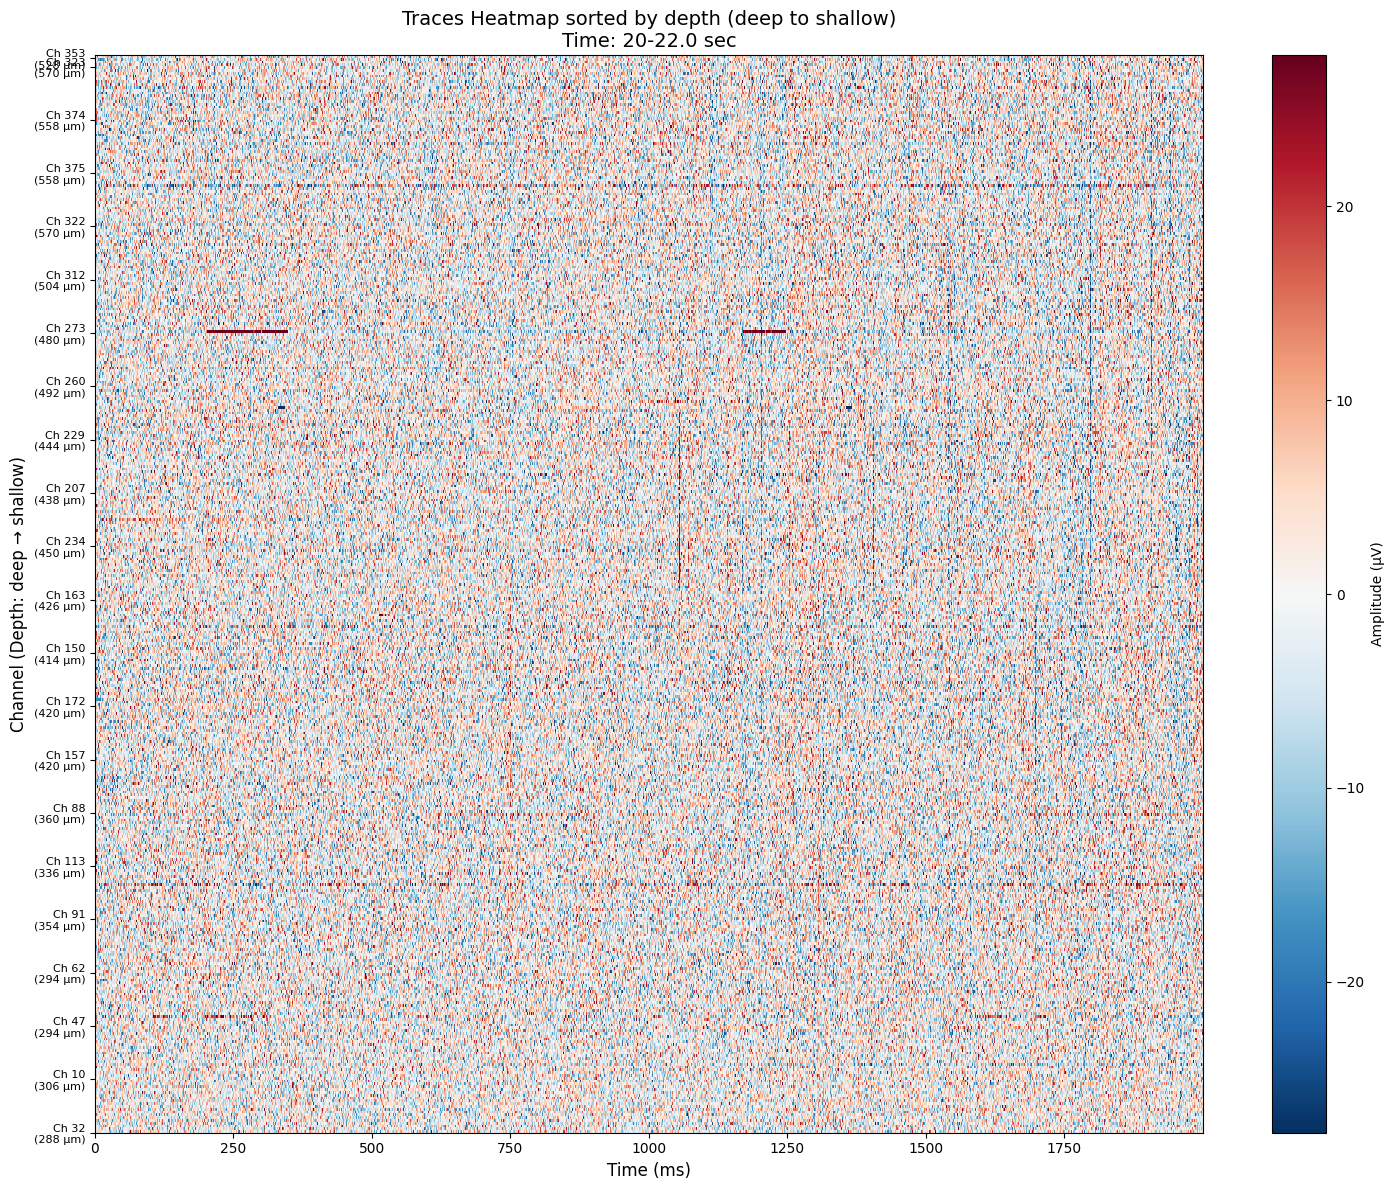

表示チャンネル数: 384
深さ範囲: 288.0 μm (最深) ～ 528.0 μm (最浅)
時間範囲: 20 ～ 22.0 秒 (60000 サンプル)
サンプリング周波数: 30000.0 Hz
ベースライン補正後のデータ範囲: -288.55 ～ 137.45 μV
データの標準偏差: 9.26 μV
ヒートマップ表示範囲: -27.79 ～ 27.79 μV (±3σ)


In [ ]:
# Traceを深さ順（y座標順）に並べてヒートマップ表示

import matplotlib.pyplot as plt
import numpy as np

# 記録データから一部の時間範囲を取得
time_start = 20  # 開始時間（秒）
time_duration = 2  # 表示する時間範囲（秒）
is_baseline_correction = True

# サンプリング周波数を取得
fs = recording.get_sampling_frequency()
num_samples = int(time_duration * fs)

# データを取得
start_frame = int(time_start * fs)
end_frame = start_frame + num_samples
traces = recording.get_traces(start_frame=start_frame, end_frame=end_frame)  # shape: (n_samples, n_channels)

# プローブの位置情報を取得
probe = recording.get_probe()
contact_positions = probe.contact_positions
xc = contact_positions[:, 0]
yc = contact_positions[:, 1]

# チャンネルIDを取得
# channel_ids = recording.get_channel_ids()
channel_ids = order_f;

# ベースラインを揃える
channel_base = traces[0:30000,:].mean(axis=0)
if is_baseline_correction:
    traces_baseline_corrected = traces - channel_base  # shape: (n_samples, n_channels)
else:
    traces_baseline_corrected = traces

# 時間軸を作成
time_axis = np.arange(num_samples) / fs * 1000  # ミリ秒単位

# ヒートマップをプロット
# データを転置して、行=チャンネル（深さ順）、列=時間になるようにする
heatmap_data = traces_baseline_corrected.T  # shape: (n_channels, n_samples)

# スパイクが見やすくなるように表示範囲を設定
# 標準偏差の数倍の範囲に制限（外れ値を除外）
std_value = np.std(heatmap_data)
mean_value = np.mean(heatmap_data)
n_std = 3  # 標準偏差の倍数（調整可能）

# 表示範囲を設定（平均±n_std*標準偏差）
vmin = mean_value - n_std * std_value
vmax = mean_value + n_std * std_value

# プロット
fig, ax = plt.subplots(figsize=(15, 12))

# ヒートマップを表示（表示範囲を制限）
im = ax.imshow(heatmap_data, aspect='auto', cmap='RdBu_r', 
               extent=[time_axis[0], time_axis[-1], 0, len(channel_ids)],
               interpolation='nearest', origin='lower',
               vmin=vmin, vmax=vmax)

# カラーバーを追加
cbar = plt.colorbar(im, ax=ax, label='Amplitude (μV)')

# y軸のラベルを設定（深さ情報を表示）
# いくつかの深さ位置にラベルを追加
y_tick_positions = []
y_tick_labels = []
n_ticks = 20  # 表示するラベルの数
step = max(1, len(channel_ids) // n_ticks)
for i in range(0, len(channel_ids), step):
    y_tick_positions.append(i)
    y_tick_labels.append(f"Ch {channel_ids[i]}\n({yc[i]:.0f} μm)")

# 最後のチャンネルも必ず表示
if len(channel_ids) - 1 not in y_tick_positions:
    y_tick_positions.append(len(channel_ids) - 1)
    y_tick_labels.append(f"Ch {channel_ids[-1]}\n({yc[-1]:.0f} μm)")

ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, fontsize=8)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Channel (Depth: deep → shallow)', fontsize=12)
ax.set_title(f'Traces Heatmap sorted by depth (deep to shallow)\nTime: {time_start}-{time_start+time_duration:.1f} sec', fontsize=14)

plt.tight_layout()
plt.show()

# 統計情報を表示
print(f"表示チャンネル数: {len(channel_ids)}")
print(f"深さ範囲: {yc[0]:.1f} μm (最深) ～ {yc[-1]:.1f} μm (最浅)")
print(f"時間範囲: {time_start} ～ {time_start+time_duration:.1f} 秒 ({num_samples} サンプル)")
print(f"サンプリング周波数: {fs} Hz")
print(f"ベースライン補正後のデータ範囲: {heatmap_data.min():.2f} ～ {heatmap_data.max():.2f} μV")
print(f"データの標準偏差: {std_value:.2f} μV")
print(f"ヒートマップ表示範囲: {vmin:.2f} ～ {vmax:.2f} μV (±{n_std}σ)")


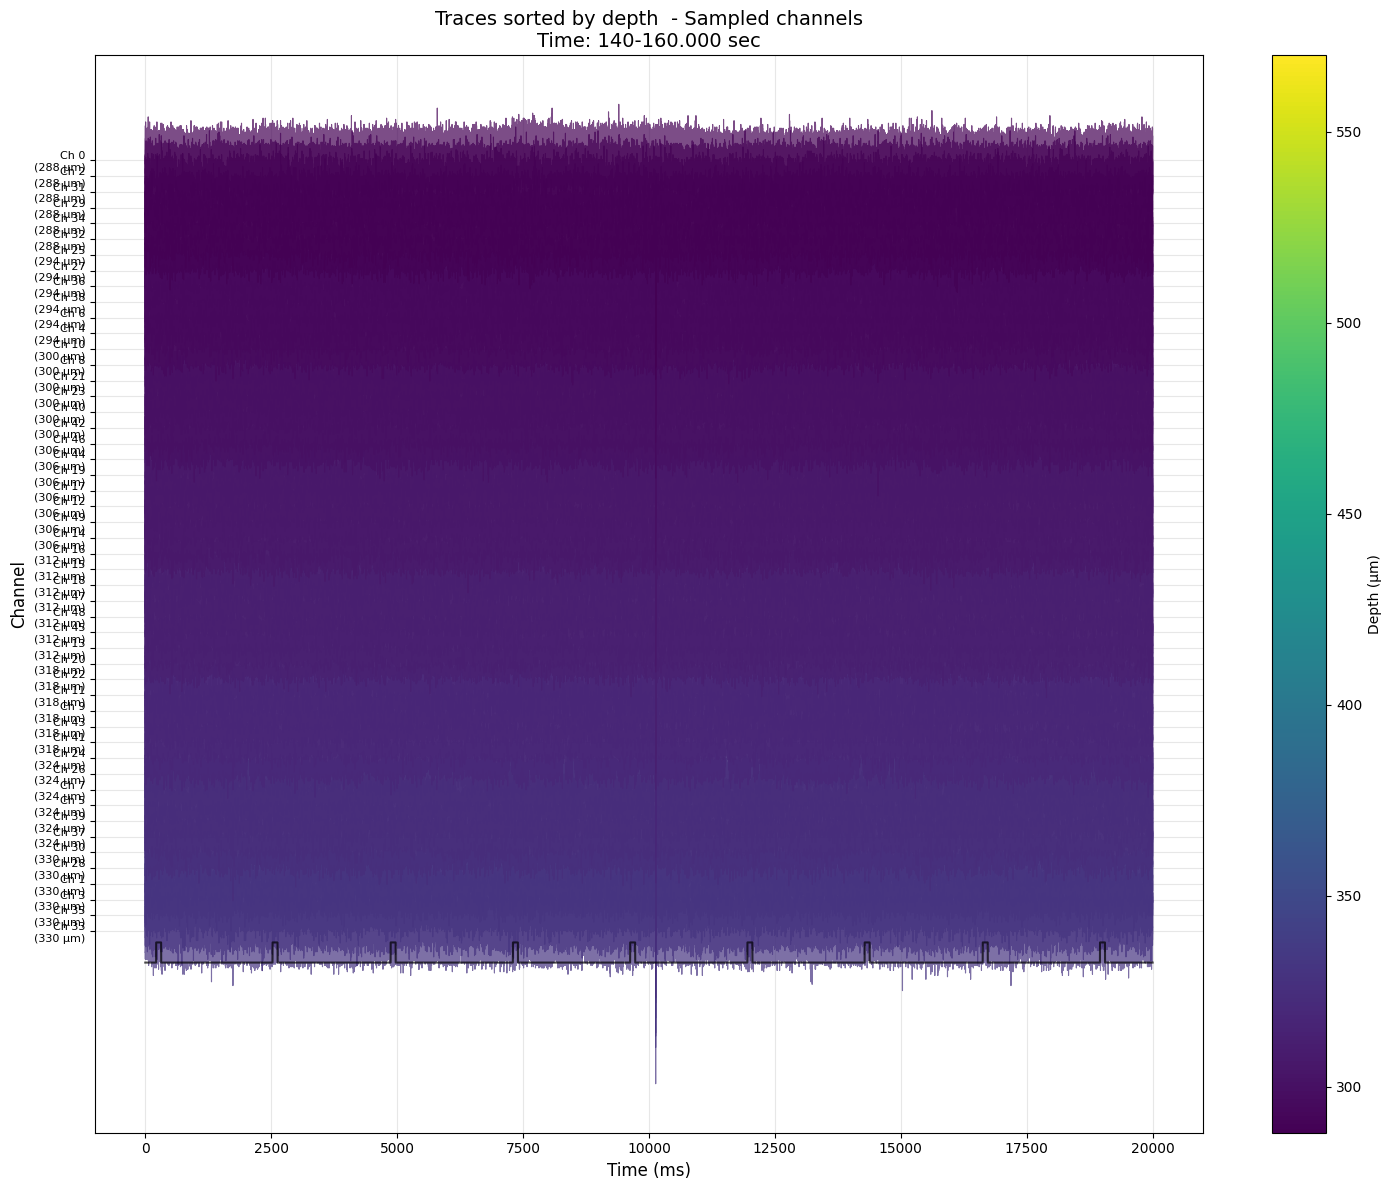

全チャンネル数: 50
表示チャンネル数: 50
深さ範囲: 330.0 μm (最深) ～ 288.0 μm (最浅)
時間範囲: 140 ～ 160.000 秒 (600000 サンプル)
サンプリング周波数: 30000.0 Hz


In [ ]:
# Traceを深さ順（y座標順）に並べて波形表示（サンプリング）

import matplotlib.pyplot as plt
import numpy as np

# 記録データから一部の時間範囲を取得
time_start = 140  # 開始時間（秒）
time_duration = 20  # 表示する時間範囲（秒）- 波形を見やすくするため短めに

# 0, 40, 80, 100, 140

# 表示するチャンネルIDを指定（例：最後の100チャンネルから最初の99チャンネル）
# または、特定のチャンネルIDのリストを指定（例：[0, 10, 20, 30, ...]）
# または、Noneにすると全チャンネルを表示
show_channel_ids = recording.get_channel_ids()[:50] # チャンネルIDのリスト
# show_channel_ids = None  # 全チャンネルを表示する場合はNone

# サンプリング周波数を取得
fs = recording.get_sampling_frequency()
num_samples = int(time_duration * fs)

# プローブの位置情報を取得
probe = recording.get_probe()
contact_positions = probe.contact_positions
xc = contact_positions[:, 0]
yc = contact_positions[:, 1]

# 全チャンネルIDを取得（recordingはすでに深さ順に並び替えられている）
all_channel_ids = recording.get_channel_ids()  # 深さ順（深い順）に並び替え済み

# 表示するチャンネルIDを決定
if show_channel_ids is None:
    show_channel_ids = all_channel_ids

# 選択されたチャンネルIDに対応する深さ情報を取得
selected_depths = []
selected_channel_ids_list = []
for ch_id in show_channel_ids:
    if ch_id in all_channel_ids:
        idx = np.where(all_channel_ids == ch_id)[0][0]
        selected_depths.append(yc[idx])
        selected_channel_ids_list.append(ch_id)
    else:
        print(f"警告: チャンネルID {ch_id} が見つかりませんでした。")

# 深さ順（深い順）に並び替える
selected_depths = np.array(selected_depths)
selected_channel_ids_list = np.array(selected_channel_ids_list)

# 深さの降順（深い順）でソート
depth_sort_indices = np.argsort(selected_depths)[::-1]  # 降順ソート
sorted_channel_ids = selected_channel_ids_list[depth_sort_indices]
sorted_depths = selected_depths[depth_sort_indices]

# データを取得（深さ順に並び替えたチャンネルIDの順序で）
start_frame = int(time_start * fs)
end_frame = start_frame + num_samples
traces = recording.select_channels(sorted_channel_ids).get_traces(start_frame=start_frame, end_frame=end_frame)  # shape: (n_samples, n_channels)

# 深さ順に並び替えられたデータ
sorted_traces = traces  # すでに深さ順に並び替えられている
sorted_yc = sorted_depths
sorted_xc = np.array([xc[np.where(all_channel_ids == ch_id)[0][0]] for ch_id in sorted_channel_ids])

# 表示するチャンネルのインデックス（すべて表示する場合は全インデックス）
show_indices = list(range(len(sorted_channel_ids)))

# ベースラインを揃える（各チャンネルの平均値を引く）
channel_means = np.mean(sorted_traces, axis=0, keepdims=True)  # shape: (1, n_channels)
sorted_traces_baseline_corrected = sorted_traces - channel_means  # shape: (n_samples, n_channels)

# 時間軸を作成
time_axis = np.arange(num_samples) / fs * 1000  # ミリ秒単位

# 表示するチャンネル数を決定（全チャンネルではなくサンプリング）
n_channels_total = len(show_indices)
n_channels_to_show = min(50, n_channels_total)  # 最大50チャンネル表示

# 等間隔でチャンネルをサンプリング
if n_channels_to_show < n_channels_total:
    step = n_channels_total / n_channels_to_show
    sampled_indices = [show_indices[int(i * step)] for i in range(n_channels_to_show)]
    # 最後のチャンネルも必ず含める
    if sampled_indices[-1] != show_indices[-1]:
        sampled_indices.append(show_indices[-1])
    show_indices = sampled_indices

# プロット
fig, ax = plt.subplots(figsize=(15, 12))

# オフセットを計算（各チャンネルを縦方向にずらす）
trace_offset = 50  # 各チャンネル間のオフセット（μV）
amp = 4
# サンプリングされたチャンネルのtraceをプロット
for i, ch_idx in enumerate(show_indices):
    trace = sorted_traces_baseline_corrected[:, ch_idx]
    y_pos = sorted_yc[ch_idx]
    
    # オフセットを追加
    offset_trace = trace * amp + i * trace_offset
    
    # プロット（深さ情報を色で表現）
    color = plt.cm.viridis((y_pos - yc.min()) / (yc.max() - yc.min()))
    ax.plot(time_axis, offset_trace, linewidth=0.8, color=color, alpha=0.7)

# SYNCチャンネルのデータを取得（同じ時間範囲で）
sync_trace = sync_recording.get_traces(start_frame=start_frame, end_frame=end_frame)  # shape: (n_samples, 1)
sync_trace = sync_trace[:, 0]  # 1次元配列に変換
ax.plot(time_axis, sync_trace + -2 * trace_offset, linewidth=1.5, color='black', alpha=0.7)

# y軸のラベルを設定（深さ情報を表示）
y_tick_positions = []
y_tick_labels = []
for i, ch_idx in enumerate(show_indices):
    y_tick_positions.append(i * trace_offset)
    y_tick_labels.append(f"Ch {sorted_channel_ids[ch_idx]}\n({sorted_yc[ch_idx]:.0f} μm)")

ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, fontsize=8)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Channel', fontsize=12)
ax.set_title(f'Traces sorted by depth  - Sampled channels\nTime: {time_start}-{time_start+time_duration:.3f} sec', fontsize=14)
ax.grid(True, alpha=0.3)

# カラーバーを追加（深さの色スケール）
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=yc.min(), vmax=yc.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Depth (μm)')

plt.tight_layout()
plt.show()

# 統計情報を表示
print(f"全チャンネル数: {n_channels_total}")
print(f"表示チャンネル数: {len(show_indices)}")
print(f"深さ範囲: {sorted_yc[0]:.1f} μm (最深) ～ {sorted_yc[-1]:.1f} μm (最浅)")
print(f"時間範囲: {time_start} ～ {time_start+time_duration:.3f} 秒 ({num_samples} サンプル)")
print(f"サンプリング周波数: {fs} Hz")


Loaded contamination percentage from Kilosort4 output: 438 units
~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


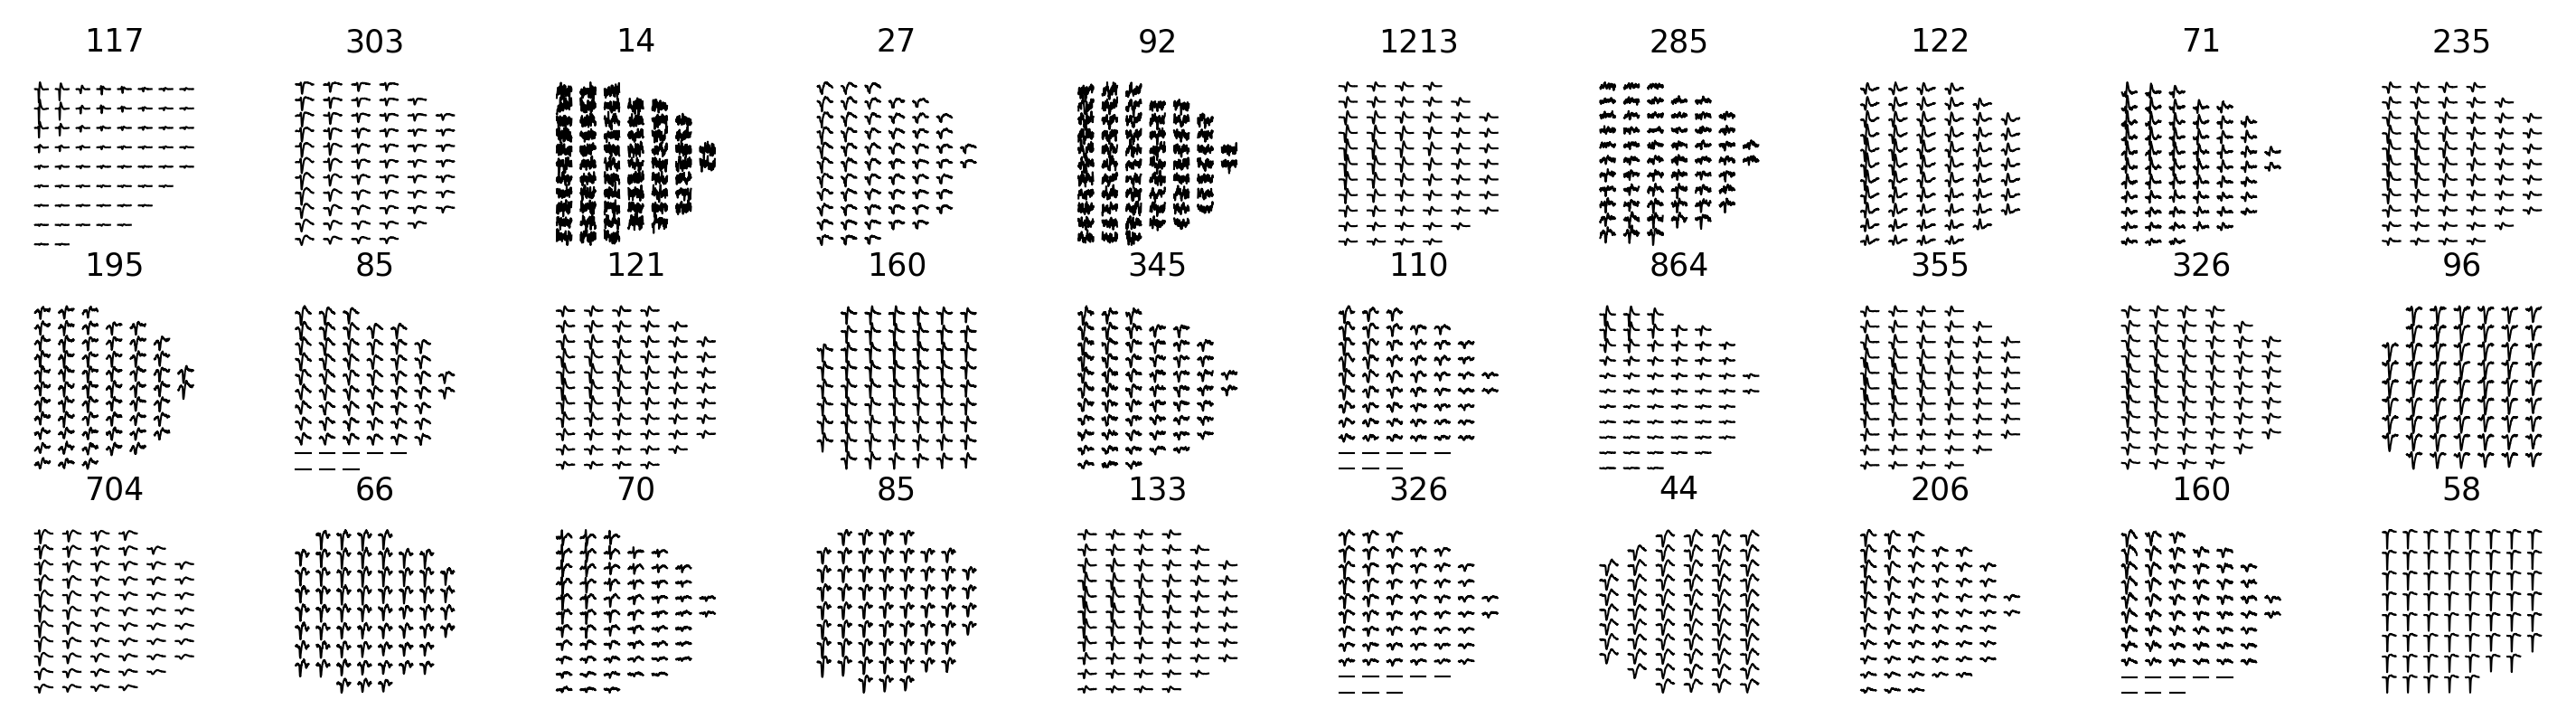

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


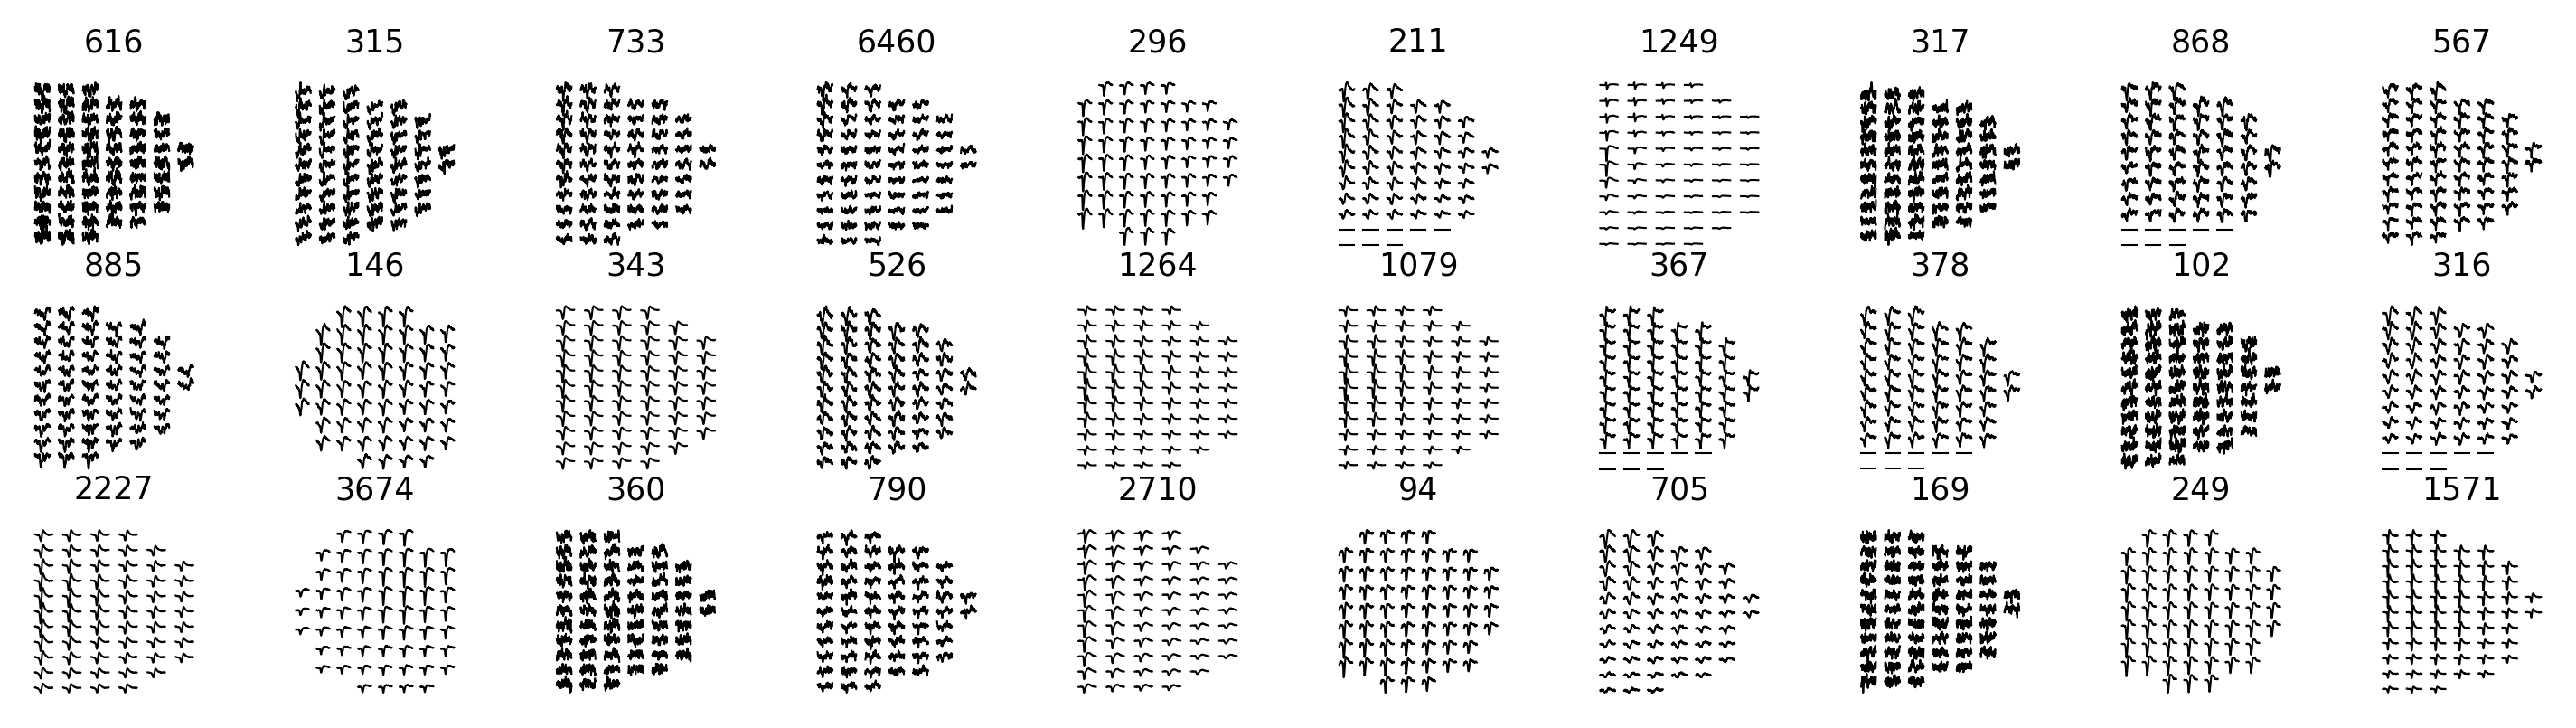

In [ ]:
# SpikeInterfaceのanalyzerを使ってKilosort4の可視化を再現

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

# analyzerをロード（既に作成されている場合）
# もしanalyzerがまだ定義されていない場合は、以下のコメントを外してください:
# analyzer = si.load_sorting_analyzer(folder=exp_dir / "kilosort4" / "analyzer")

# 必要なextensionを計算
if not analyzer.has_extension("templates"):
    analyzer.compute("random_spikes")
    analyzer.compute("waveforms")
    analyzer.compute("templates")

# probe geometryを取得
probe = recording.get_probe()
contact_positions = probe.contact_positions
xc = contact_positions[:, 0]
yc = contact_positions[:, 1]

# templatesを取得
templates_ext = analyzer.get_extension("templates")
templates = templates_ext.get_data(operator="average")  # shape: (n_units, n_samples, n_channels)

# Kilosort4の出力から直接contamination percentageを読み込む（メモリ効率的）
# または、既に計算されているquality_metricsから取得を試みる
contam_pct = None

# 方法1: Kilosort4の出力ファイルから直接読み込む
try:
    res_dir = dict_path["exp"] / sorter / name_thisparam / "sorting" / "sorter_output"
    cluster_contam_file = res_dir / "cluster_ContamPct.tsv"
    if cluster_contam_file.exists():
        cluster_contam_df = pd.read_csv(cluster_contam_file, sep="\t")
        # unit_idsを取得（後で使用するため）
        unit_ids = analyzer.unit_ids
        
        # cluster_ContamPctファイルの構造に応じて調整
        if 'ContamPct' in cluster_contam_df.columns:
            # cluster_idカラムがある場合は、unit_idsとマッピング
            if 'cluster_id' in cluster_contam_df.columns:
                cluster_ids = cluster_contam_df['cluster_id'].values
                contam_values = cluster_contam_df['ContamPct'].values
                # unit_idsとcluster_idsをマッピング
                contam_pct = np.zeros(len(unit_ids))
                for i, unit_id in enumerate(unit_ids):
                    if unit_id in cluster_ids:
                        idx = np.where(cluster_ids == unit_id)[0][0]
                        contam_pct[i] = contam_values[idx]
            else:
                # cluster_idカラムがない場合は、順序が一致していると仮定
                contam_pct = cluster_contam_df['ContamPct'].values
                if len(contam_pct) != len(unit_ids):
                    print(f"Warning: Number of units mismatch. cluster_ContamPct: {len(contam_pct)}, unit_ids: {len(unit_ids)}")
                    # 短い方に合わせる
                    min_len = min(len(contam_pct), len(unit_ids))
                    contam_pct = contam_pct[:min_len]
        elif len(cluster_contam_df.columns) > 0:
            # 最初の数値カラムをcontaminationとして使用
            contam_pct = cluster_contam_df.iloc[:, -1].values
            if len(contam_pct) != len(unit_ids):
                min_len = min(len(contam_pct), len(unit_ids))
                contam_pct = contam_pct[:min_len]
        
        print(f"Loaded contamination percentage from Kilosort4 output: {len(contam_pct)} units")
except Exception as e:
    print(f"Could not load from Kilosort4 output: {e}")

# 方法2: 既に計算されているquality_metricsから取得
if contam_pct is None and analyzer.has_extension("quality_metrics"):
    try:
        qm_ext = analyzer.get_extension("quality_metrics")
        qm_data = qm_ext.get_data()
        for col_name in ['contamination', 'contamination_rate', 'contamination_ratio']:
            if col_name in qm_data.columns:
                contam_pct = qm_data[col_name].values * 100  # パーセンテージに変換
                print(f"Loaded contamination percentage from quality_metrics: {col_name}")
                break
    except Exception as e:
        print(f"Could not load from quality_metrics: {e}")

# 方法3: デフォルト値を使用（すべてのユニットをgoodとして扱う）
if contam_pct is None:
    print("Warning: contamination percentage not found. Using default threshold (all units as good).")
    contam_pct = np.zeros(len(analyzer.unit_ids))

# unit_idsを取得（まだ取得していない場合）
if 'unit_ids' not in locals():
    unit_ids = analyzer.unit_ids

# contam_pctの長さをunit_idsに合わせる
if contam_pct is not None and len(contam_pct) != len(unit_ids):
    print(f"Warning: contam_pct length ({len(contam_pct)}) != unit_ids length ({len(unit_ids)}). Adjusting...")
    if len(contam_pct) < len(unit_ids):
        # 足りない分を0で埋める
        contam_pct = np.pad(contam_pct, (0, len(unit_ids) - len(contam_pct)), 'constant', constant_values=0)
    else:
        # 長すぎる場合は切り詰める
        contam_pct = contam_pct[:len(unit_ids)]

# 各ユニットのスパイク数を取得
spike_counts = []
for unit_id in unit_ids:
    spike_times = analyzer.sorting.get_unit_spike_train(unit_id)
    spike_counts.append(len(spike_times))
spike_counts = np.array(spike_counts)

# 各テンプレートの最良チャンネルを取得（最大振幅のチャンネル）
chan_best = []
for i, unit_id in enumerate(unit_ids):
    template = templates[i]  # shape: (n_samples, n_channels)
    # 各チャンネルの最大振幅を計算
    max_amps = np.max(np.abs(template), axis=0)
    best_chan = np.argmax(max_amps)
    chan_best.append(best_chan)
chan_best = np.array(chan_best)

# good unitsとmua unitsを分類
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]

gstr = ['good', 'mua']
nc = 60  # number of channels to show

for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j == 0 else mua_units
    
    if len(units) == 0:
        print(f"No {gstr[j]} units found.")
        continue
    
    n_units_to_show = min(30, len(units))
    
    # グリッドサイズを動的に計算（空白を避けるため）
    # 最大30ユニットを表示、3行×10列のグリッドを使用
    n_cols = 10
    n_rows = int(np.ceil(n_units_to_show / n_cols))
    
    fig = plt.figure(figsize=(12, 3 * n_rows / 3), dpi=300)
    grid = gridspec.GridSpec(n_rows, n_cols, figure=fig, hspace=0.25, wspace=0.5)
    
    # 重複なしでランダムにユニットを選択
    if len(units) > n_units_to_show:
        # 十分なユニットがある場合は、重複なしでランダムサンプリング
        selected_unit_indices = np.random.choice(units, size=n_units_to_show, replace=False)
    else:
        # ユニット数が少ない場合は、すべて使用（順序はランダム化）
        selected_unit_indices = np.random.permutation(units)[:n_units_to_show]
    
    for k in range(n_units_to_show):
        wi = selected_unit_indices[k]
        
        unit_id = unit_ids[wi]
        wv = templates[wi].copy()  # shape: (n_samples, n_channels)
        cb = chan_best[wi]
        nsp = spike_counts[wi]
        
        ax = fig.add_subplot(grid[k // n_cols, k % n_cols])
        n_chan = wv.shape[-1]
        
        # 最良チャンネルの物理的位置を取得
        best_x, best_y = xc[cb], yc[cb]
        
        # すべてのチャンネルとの物理的距離を計算
        distances = np.sqrt((xc - best_x)**2 + (yc - best_y)**2)
        
        # 距離が近い順にソートして、nc個のチャンネルを選択
        nearest_indices = np.argsort(distances)[:nc]
        nearest_indices = np.sort(nearest_indices)  # 元の順序を保持するためにソート
        
        # 選択されたチャンネルの波形と位置を抽出
        wv = wv[:, nearest_indices]
        x0, y0 = xc[nearest_indices], yc[nearest_indices]
        
        # 各チャンネルのベースラインを0に揃える（平均値を引く）
        wv_baseline_corrected = wv.copy()
        for ch_idx in range(wv.shape[1]):
            channel_mean = np.mean(wv[:, ch_idx])
            wv_baseline_corrected[:, ch_idx] = wv[:, ch_idx] - channel_mean
        
        # 振幅スケールを電極間隔に合わせて調整
        # y方向の電極間隔を計算
        if len(y0) > 1:
            y_spacing = np.median(np.diff(np.sort(np.unique(y0))))
        else:
            y_spacing = 10  # デフォルト値
        
        # 波形の最大振幅を取得
        max_amp = np.max(np.abs(wv_baseline_corrected))
        if max_amp > 0:
            # 電極間隔の80%に収まるようにスケールを調整
            amp = (y_spacing * 0.8) / max_amp
        else:
            amp = 1
        
        for ii, (xi, yi) in enumerate(zip(x0, y0)):
            t = np.arange(-wv_baseline_corrected.shape[0] // 2, wv_baseline_corrected.shape[0] // 2, 1, 'float32')
            t /= wv_baseline_corrected.shape[0] / 10 + 15
            ax.plot(xi + t, yi + wv_baseline_corrected[:, ii] * amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    
    plt.show()


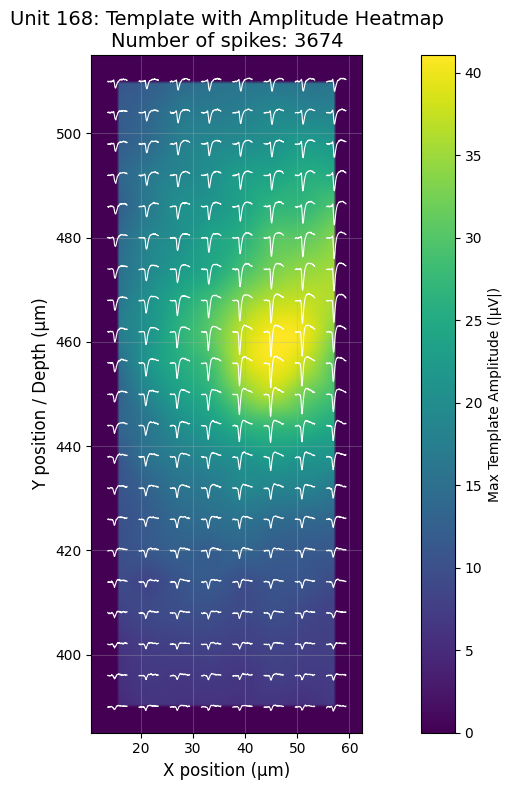

Unit ID: 168
Number of spikes: 3674
Template shape: (90, 384)
Best channel: 211 (x=39.5 μm, y=450.0 μm)
Displayed channels: 168 (nearest to best channel)
Depth range: 390.0 μm (deepest) ～ 510.0 μm (shallowest)
Template amplitude range: 0.00 ～ 40.57 |μV|
Colorbar range: 0.00 ～ 41.07 |μV|


In [ ]:
# 1つのユニットについて、テンプレートのプロットの背景に振幅値をカラーマップで表示

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# 必要なextensionを計算（既に計算済みの場合はスキップ）
if not analyzer.has_extension("templates"):
    analyzer.compute("random_spikes")
    analyzer.compute("waveforms")
    analyzer.compute("templates")

# probe geometryを取得
probe = recording.get_probe()
contact_positions = probe.contact_positions
xc = contact_positions[:, 0]
yc = contact_positions[:, 1]

# templatesを取得
templates_ext = analyzer.get_extension("templates")
templates = templates_ext.get_data(operator="average")  # shape: (n_units, n_samples, n_channels)

# unit_idsを取得
unit_ids = analyzer.unit_ids

# 表示するユニットを選択（最初のユニット、またはインデックスを指定）
unit_index = 168  # 表示したいユニットのインデックスを指定
unit_id = unit_ids[unit_index]

# テンプレートを取得
template = templates[unit_index]  # shape: (n_samples, n_channels)

# 各チャンネルの最大振幅を計算して最良チャンネルを取得
max_amps = np.max(np.abs(template), axis=0)
best_chan = np.argmax(max_amps)

# 最良チャンネルの物理的位置を取得
best_x, best_y = xc[best_chan], yc[best_chan]

# ベストチャンネルから上下Nチャンネル、横は全部を選択
n_channels_up_down = 10  # 上下に表示するチャンネル数（ベストチャンネルから上下それぞれn_channels_up_down個）

# ベストチャンネルのY座標を取得
best_y_coord = best_y

# Y座標の範囲を計算（ベストチャンネルから上下Nチャンネル分）
# 電極間隔を計算
if len(yc) > 1:
    y_spacing = np.median(np.diff(np.sort(np.unique(yc))))
else:
    y_spacing = 10  # デフォルト値

# Y座標の範囲を設定
y_min_range = best_y_coord - n_channels_up_down * y_spacing
y_max_range = best_y_coord + n_channels_up_down * y_spacing

# そのY範囲内のすべてのチャンネルを選択（X方向は全部）
nearest_indices = np.where((yc >= y_min_range) & (yc <= y_max_range))[0]
nearest_indices = np.sort(nearest_indices)  # 元の順序を保持するためにソート
nc = len(nearest_indices)  # 選択されたチャンネル数

# 選択されたチャンネルの波形と位置を抽出
wv = template[:, nearest_indices]  # shape: (n_samples, nc)
x0, y0 = xc[nearest_indices], yc[nearest_indices]

# 各チャンネルのベースラインを0に揃える（平均値を引く）
wv_baseline_corrected = wv.copy()
for ch_idx in range(wv.shape[1]):
    channel_mean = np.mean(wv[:, ch_idx])
    wv_baseline_corrected[:, ch_idx] = wv[:, ch_idx] - channel_mean

# 振幅スケールを電極間隔に合わせて調整
# y方向の電極間隔を計算
if len(y0) > 1:
    y_spacing = np.median(np.diff(np.sort(np.unique(y0))))
else:
    y_spacing = 10  # デフォルト値

# 波形の最大振幅を取得
max_amp = np.max(np.abs(wv_baseline_corrected))
if max_amp > 0:
    # 電極間隔の80%に収まるようにスケールを調整
    amp = (y_spacing * 0.8) / max_amp
else:
    amp = 1
# amp = 1;

# プロット
fig, ax = plt.subplots(figsize=(12, 8))

# 背景にカラーマップを表示（テンプレートの振幅値を2D空間にマッピング）
# 各電極位置での最大振幅値を計算
template_abs = np.abs(wv_baseline_corrected)  # shape: (n_samples, nc)
max_amps_per_channel = np.max(template_abs, axis=0)  # 各チャンネルの最大振幅

# 物理的な範囲を取得
x_min, x_max = x0.min() - 5, x0.max() + 5
y_min, y_max = y0.min() - 5, y0.max() + 5

# 2Dグリッドを作成（カラーマップ用）
# x方向とy方向の解像度を設定
x_resolution = 100
y_resolution = 200

# グリッド座標を作成
x_grid = np.linspace(x_min, x_max, x_resolution)
y_grid = np.linspace(y_min, y_max, y_resolution)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# 各グリッドポイントでの振幅値を補間
# 各電極位置（x0, y0）での最大振幅値をグリッドに補間
heatmap_data = griddata((x0, y0), max_amps_per_channel, (X_grid, Y_grid), 
                        method='cubic', fill_value=0)

# カラーバーの最小値と最大値を設定（調整可能）
# デフォルト値はデータの最小値と最大値を使用
# 必要に応じて以下の値を変更してください
vmin_custom = None  # Noneの場合はデータの最小値を使用
vmax_custom = None  # Noneの場合はデータの最大値を使用

# カスタム値が指定されていない場合は、データの範囲を使用
if vmin_custom is None:
    vmin_custom = np.nanmin(heatmap_data)
if vmax_custom is None:
    vmax_custom = np.nanmax(heatmap_data)

# カラーマップを表示（2D空間にマッピング）
im = ax.imshow(heatmap_data, extent=[x_min, x_max, y_min, y_max], 
               origin='lower', cmap='viridis', alpha=1.0,
               interpolation='bilinear', aspect='auto',
               vmin=vmin_custom, vmax=vmax_custom)

# カラーバーを追加
cbar = plt.colorbar(im, ax=ax, label='Max Template Amplitude (|μV|)')

# 波形をプロット（カラーマップの上に重ねる）
# 元のコード（Cell 22）と同様に、物理的な位置（xi, yi）にプロット
for ii, (xi, yi) in enumerate(zip(x0, y0)):
    t = np.arange(-wv_baseline_corrected.shape[0] // 2, wv_baseline_corrected.shape[0] // 2, 1, 'float32')
    t /= wv_baseline_corrected.shape[0] / 10 + 15
    # 物理的な位置（xi, yi）に波形をプロット（元のコードと同じ）
    ax.plot(xi + t, yi + wv_baseline_corrected[:, ii] * amp, 
            lw=0.8, color='w', alpha= 1.0)

# 軸の設定
ax.set_xlabel('X position (μm)', fontsize=12)
ax.set_ylabel('Y position / Depth (μm)', fontsize=12)
ax.set_aspect('equal', adjustable='box')

# スパイク数を取得
spike_times = analyzer.sorting.get_unit_spike_train(unit_id)
nsp = len(spike_times)

ax.set_title(f'Unit {unit_id}: Template with Amplitude Heatmap\nNumber of spikes: {nsp}', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 統計情報を表示
print(f"Unit ID: {unit_id}")
print(f"Number of spikes: {nsp}")
print(f"Template shape: {template.shape}")
print(f"Best channel: {best_chan} (x={best_x:.1f} μm, y={best_y:.1f} μm)")
print(f"Displayed channels: {nc} (nearest to best channel)")
print(f"Depth range: {y0.min():.1f} μm (deepest) ～ {y0.max():.1f} μm (shallowest)")
print(f"Template amplitude range: {template_abs.min():.2f} ～ {template_abs.max():.2f} |μV|")
print(f"Colorbar range: {vmin_custom:.2f} ～ {vmax_custom:.2f} |μV|")

fig.savefig("template_with_amplitude_heatmap.svg", format="svg")


In [ ]:
# matplotlibで利用可能なカラーマップ（cmap）の一覧

import matplotlib.pyplot as plt

# すべてのカラーマップを取得（反転版を除く）
all_cmaps = sorted([name for name in plt.colormaps() if not name.endswith('_r')])

print(f"利用可能なカラーマップ: 全{len(all_cmaps)}種類\n")

# 主要なカテゴリ別に分類
print("【Sequential（連続的）- 低値から高値へ】")
sequential = ['viridis', 'plasma', 'inferno', 'magma', 'hot', 'cool', 'spring', 
              'summer', 'autumn', 'winter', 'gray', 'bone', 'copper', 'pink',
              'YlOrRd', 'YlOrBr', 'YlGnBu', 'YlGn', 'Reds', 'RdPu', 'Purples',
              'PuRd', 'PuBu', 'Oranges', 'OrRd', 'Greys', 'Greens', 'GnBu',
              'BuPu', 'BuGn', 'Blues']
print([c for c in sequential if c in all_cmaps])

print("\n【Diverging（発散的）- 中央値から両端へ】")
diverging = ['RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy']
print([c for c in diverging if c in all_cmaps])

print("\n【Cyclic（周期的）】")
cyclic = ['hsv', 'twilight', 'twilight_shifted']
print([c for c in cyclic if c in all_cmaps])

print("\n【Qualitative（質的）】")
qualitative = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2',
               'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
print([c for c in qualitative if c in all_cmaps])

print(f"\n全カラーマップ一覧（最初の50個）:")
for i, cmap in enumerate(all_cmaps[:50]):
    print(f"  {cmap}", end="  ")
    if (i + 1) % 5 == 0:
        print()
print(f"\n... 他{len(all_cmaps) - 50}個")

print("\n【推奨】")
print("画像のような紫→青→緑→黄色のグラデーションには:")
print("  - 'viridis' (デフォルト推奨)")
print("  - 'plasma' (紫→ピンク→黄色)")
print("  - 'inferno' (黒→赤→黄色)")
print("  - 'magma' (黒→紫→ピンク→黄色)")
print("\n現在使用中の 'hot' は: 黒→赤→黄色→白")
print("\n詳細: https://matplotlib.org/stable/tutorials/colors/colormaps.html")


利用可能なカラーマップ: 全90種類

【Sequential（連続的）- 低値から高値へ】
['viridis', 'plasma', 'inferno', 'magma', 'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'gray', 'bone', 'copper', 'pink', 'YlOrRd', 'YlOrBr', 'YlGnBu', 'YlGn', 'Reds', 'RdPu', 'Purples', 'PuRd', 'PuBu', 'Oranges', 'OrRd', 'Greys', 'Greens', 'GnBu', 'BuPu', 'BuGn', 'Blues']

【Diverging（発散的）- 中央値から両端へ】
['RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic', 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy']

【Cyclic（周期的）】
['hsv', 'twilight', 'twilight_shifted']

【Qualitative（質的）】
['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']

全カラーマップ一覧（最初の50個）:
  Accent    Blues    BrBG    BuGn    BuPu  
  CMRmap    Dark2    GnBu    Grays    Greens  
  Greys    OrRd    Oranges    PRGn    Paired  
  Pastel1    Pastel2    PiYG    PuBu    PuBuGn  
  PuOr    PuRd    Purples    RdBu    RdGy  
  RdPu    RdYlBu    RdYlGn    Reds    Set1  
  Set2    Set3    Spectral    Wistia    YlGn  
